# Deep SITH Exploration

## Breakdown 

@deep_isith.py: Python script that is called to actually create an instance of the network. Deep SITH inherits SITH features, so non-optional SITH parameters need to be included as well, or previously designated. 

    A Module built for SITH like an LSTM

    Parameters
    ----------
    
    layer_params: list
        A list of dictionaries for each layer in the desired DeepSITH. All
        of the parameters needed for the SITH part of the Layers, as well as
        a hidden_size and optional act_func are required to be present.

            
    layer_params keys
    -----------------
    in_features: int 
        Number of tracked features in the network.
    tau_min: float (default = 0.1)
        The center of the temporal receptive field for the first taustar produced.
    tau_max: float (default = 100)
        The center of the temporal receptive field for the last taustar produced.
    buff_max: int (default = None)
        The maximum time in which the filters go into the past. NOTE: In order to 
        achieve as few edge effects as possible, buff_max needs to be bigger than
        tau_max, and dependent on k, such that the filters have enough time to reach
        very close to 0.0. Plot the filters and you will see them go to 0.
    k: int (default = 50)
        Temporal Specificity of the taustars. If this number is high, then taustars
        will always be more narrow.
    ntau: int (default = 50)
        Number of taustars produced, spread out logarithmically.
    dt: float (default = 1)
        The time delta of the model. The there will be int(buff_max/dt) filters per
        taustar. Essentially this is the base rate of information being presented to the
        model
    g: float (default = 0.0)
        Typically between 0 and 1. This parameter is the scaling factor of the output
        of the module. If set to 1, the output amplitude for a delta function will be
        identical through time. If set to 0, the amplitude will decay into the past,
        getting smaller and smaller. This value should be picked on an application to 
        application basis.
    ttype: Torch Tensor
        This is the type we set the internal mechanism of the model to before running.
        In order to calculate the filters, we must use a DoubleTensor, but this is no
        longer necessary after they are calculated. By default we set the filters to 
        be FloatTensors. NOTE: If you plan to use CUDA, you need to pass in a
        cuda.FloatTensor as the ttype, as using .cuda() will not put these filters on 
        the gpu. 
    hidden_size: int (default in_features)
        The size of the output of the hidden layer. Please note that the
        in_features parameter for the next layer's SITH representation should be
        equal to the previous layer's hidden_size. This parameter will default
        to the in_features of the current SITH layer if not specified.
    act_func: torch.nn.Module (default None)
        The torch layer of the desired activation function, or None if no
        there is no desired activation function between layers.
        """

#### Update: 11/01/2020
- Used Yibo's code for most of the preprocessing. 

### Set-up

In [ ]:
!python /sfs/qumulo/qhome/aa9yk/Capstone/SITH_Layer/setup.py install --install-lib /home/aa9yk/.local/lib/python3.7/site-packages

In [ ]:
%matplotlib inline

In [1]:
!pip show torch

Name: torch
Version: 1.7.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /sfs/qumulo/qhome/aa9yk/.local/lib/python3.7/site-packages
Requires: future, dataclasses, typing-extensions, numpy
Required-by: 


In [63]:
import os
import sys
sys.path.append('/sfs/qumulo/qhome/aa9yk/.local/lib/python3.7/site-packages')
sys.path.append('/home/aa9yk/.local/bin')
import matplotlib.pyplot as plt
import torch
from torch import nn as nn
from math import factorial
import random
import torch.nn.functional as F
import seaborn as sn
from os.path import join
import glob
ttype = torch.cuda.LongTensor if torch.cuda.is_available() else torch.DoubleTensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using:', device)
print('Ttype:', ttype)
sys.path.append('/sfs/qumulo/qhome/aa9yk/Capstone/SITH_Layer/')
# deep_iSITH is being used here, not deep_sith
from sith import DeepSITH
from tqdm.notebook import tqdm
import pickle
from typing import List, Dict, Tuple, Any
print("Finished importing packages and modules!")

Using: cuda
Ttype: <class 'torch.cuda.LongTensor'>
Finished importing packages and modules!


### Code from Yibo's Preprocssing and iSITH 

TODO: We want to make sure that all the code can communicate with one another. We should attempt to modularize code so that we can call code that Yibo wrote in a file that I'm working on, etc. 

In [64]:
!pip install mne

Defaulting to user installation because normal site-packages is not writeable


In [65]:
import mne
import numpy as np
import pandas as pd
from mne.io import RawArray
from mne.channels import make_standard_montage
from mne.epochs import concatenate_epochs
from mne import create_info, find_events, Epochs, concatenate_raws, pick_types
from mne.decoding import CSP

def creat_mne_raw_object(fname, read_events=True):
    """
    obtained from @author: alexandrebarachant
    https://www.kaggle.com/alexandrebarachant/beat-the-benchmark-0-67
    Create a mne raw instance from csv file.
    Make sure the events and data files are in the same folder
    data are transformed into microvolts
    """
    print(fname)
    # Read EEG file
    data = pd.read_csv(fname)
    
    # get chanel names
    ch_names = list(data.columns[1:])
    
    # read EEG standard montage from mne
    #montage = make_standard_montage('standard_1005')

    ch_type = ['eeg']*len(ch_names)
    data = 1e-6*np.array(data[ch_names]).T
    
    if read_events:
        # events file
        ev_fname = fname.replace('_data','_events')
        # read event file
        events = pd.read_csv(ev_fname)
        events_names = events.columns[1:]
        events_data = np.array(events[events_names]).T
        # define channel type, the first is EEG, the last 6 are stimulations
        ch_type.extend(['stim']*6)
        ch_names.extend(events_names)
        # concatenate event file and data
        data = np.concatenate((data,events_data))
        
    # create and populate MNE info structure
    info = create_info(ch_names,sfreq=500.0, ch_types=ch_type)
    #info['filename'] = fname
    print(info)
    # create raw object 
    raw = RawArray(data,info,verbose=False)
    #print(data)
    return raw

In [66]:
# Loading in training data 
raw = creat_mne_raw_object(fname='/sfs/qumulo/qhome/aa9yk/Capstone/SIF_Capstone/train/subj9_series2_data.csv')

/sfs/qumulo/qhome/aa9yk/Capstone/SIF_Capstone/train/subj9_series2_data.csv
<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, T7, C3, Cz, ...
 chs: 32 EEG, 6 STIM
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 38
 projs: []
 sfreq: 500.0 Hz
>


<ipython-input-65-f6f8f274ee14>:45: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['BothStartLoadPhase']
  info = create_info(ch_names,sfreq=500.0, ch_types=ch_type)


### Preliminary Plotting

28 events found
Event IDs: [1]


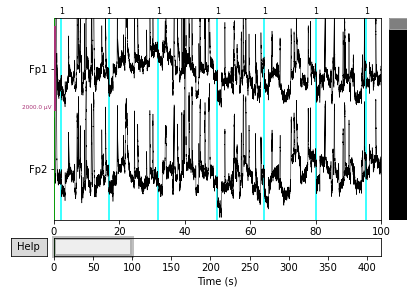

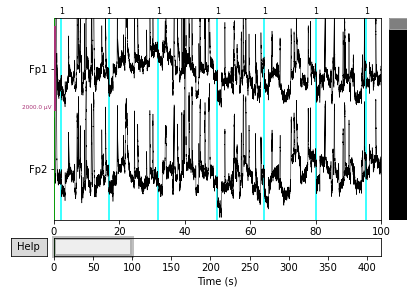

In [67]:
# Scaling is necessary to show the graphs properly
# Vertical lines indicate a event
scalings = {'eeg': 10e-4}
events = mne.find_events(raw, stim_channel=['HandStart',])
raw.plot(events=events, duration=100.0, start=0, n_channels=2, color=None,scalings=scalings)

### Data Cleaning

In [68]:
# input data, for this toy model, only consider the first 3000 unprocessed time points

## the first 6 channel are targets, for this model, only use one channel

data = raw.get_data()[:,0:3000]
input_signal = data[0:32,:]

target_signal = data[33,:] # use only the first channel target
# reformatt into tensor
input_tensor = ttype(input_signal.reshape(1,1,input_signal.shape[0],-1))


target_tensor = ttype(target_signal.reshape(1,-1))

print(target_tensor.shape)
print(input_tensor.shape)

input_tensor, target_tensor = input_tensor.cuda(), target_tensor.cuda() # add this line

torch.Size([1, 3000])
torch.Size([1, 1, 32, 3000])


### Setup DeepSITH Classifier 

In [69]:
class DeepSITH_Classifier(nn.Module):
    """
    Creates DeepSITH Classifier, which extends from the DeepSITH class. The DeepSITH
    Classifier is characterized by layers of DeepSITH and an additional linear layer as the
    last layer. 
    """

    def __init__(self, out_features:int, layer_params:List[Dict[str, Any]], dropout:int=0.5):
        """
        Initialize the DeepSITH Classifier. 
        
        Parameters
        ----------
        out_features: int
            The number of features that should be the result of the classifier. Should be
            the shape of the input. 
        layer_params: List[Dict[Any]]
            A list of dictionaries for each layer in the desired DeepSITH. All of the
            parameters needed for the SITH part of the Layers, as well as a hidden_size and
            optional act_func are required to be present.
        dropout: float (default = 0.5)
            Probability of an element to be zeroed during training. Uses torch.nn.Dropout to randomly 
            zero some of the elements of the input tensor with the given dropout probability. Effective 
            technique for regularization and preventing the co-adaptation of neurons in neural networks.
        """
        # super() function is used to give access to methods and properties of a parent or sibling class
        super(DeepSITH_Classifier, self).__init__()

        # Next layer's in_feature param should be equal to previous layer's hidden size 
        last_hidden = layer_params[-1]['hidden_size'] # The size of the output of the hidden layer
        
        # Call to DeepSITH function -- creates DeepSITH layers for each layer present in layer_params 
        self.hs = DeepSITH(layer_params=layer_params, dropout=dropout) 
        # Creation of the last linear layer in DeepSITH Classifier; Note: in_features = last_hidden 
        self.to_out = nn.Linear(last_hidden, out_features)

    def forward(self, inp):   
        """
        Takes in a t state and updates with item (Batch, 1, features, sequence)
        Returns new little t state (Batch, Taustar, features, sequence)
        """
        x = self.hs(inp) 
        x = self.to_out(x) 
        return x

### Functions for training and testing models

In [70]:
def train_model(model, signal,target,
                optimizer,
                loss_func,
                epochs=1500):
    """
    Toy model: try to predict one event (in fact there is six)
    signal needs to be in correct format: nbatch x 1 x numFeutures x time tensor.
    The inputs to the models are the time series EEG signals. All channels will be
    concatnated into one channel by iSith.
    The targets are inputed separately with [time] dimension tensor. The target is either 0 or 1 at any time point.  
    
    """
    
    loss_track = {"val":[],
                  "epoch":[],
                  "acc":[],
                  "name":[]}

    # for GPU use torch.cuda.LongTensor
    inps = signal.type(torch.cuda.DoubleTensor)
    targets = target.type(torch.cuda.DoubleTensor)
    
    progress_bar = tqdm(range(int(epochs)))
    
    for e in progress_bar:
        # Zero the gradient between each batch
        model.zero_grad()
        
        # Present an entire batch to the model
        out = model(inps)
        #print(out.shape)
        # Measure loss via CrossEntropyLoss
        loss = loss_func(out, targets)
        
        # Adjust Weights
        loss.backward()
        optimizer.step()
        
        # Record loss, epoch number, batch number in epoch, 
        # last accuracy measure, etc
        loss_track['val'].append(loss.mean().detach().cpu().numpy())
        loss_track['epoch'].append(e)
        loss_track['name'].append(model.__class__.__name__)
        
        acc = test_model(model, signal,target)
        loss_track['acc'].append(acc)
        
        # Update progress_bar
        progress_bar.set_description("%i: Loss: %0.6f, Acc: %0.4f" % (e, loss_track['val'][-1], acc))
        
    return loss_track

def test_model(model, signal,target, thresh = 0.1):
    """
    Toy model: test for accuracy
    
    signal needs to be in correct format: nchannels x 1 x 1 x time tensor.
    The inputs to the models are the time series EEG signals. All channels will be
    concatnated into one channel by iSith.
    The targets are inputed separately with 1x1x1xtime dimension tensor. The target is either 0 or 1 at any time point.  
    
    """
    inps = signal.type(torch.cuda.LongTensor)
    targets = target.type(torch.cuda.LongTensor)
    
    out = model(inps)
    result = out[:,-1]
    # Accuracy: use a threshold (currently 0.1, subject to change)
    # if value is smaller than the threshold, 0 is assigned, and 1 is assigned otherwise

    result[result<thresh] = 0
    result[result>=thresh] = 1
    correct = (result == targets).sum().detach().cpu().numpy()
    acc = correct/targets.shape[1]
    return acc

### Testing DeepSITH Classifer

Arbitraily creating test layers to make sure the DeepSITH classifer works as expected. Allows us to determine network parameters. 

In [71]:
# num of epochs to train
epochs = 30
# Just for visualizing average loss through time. 
loss_buffer_size = 100
loss_func = torch.nn.CrossEntropyLoss()


#--------------- sith layer model parameters ------------------#
sith_params2 = {"in_features":32, # make sure this mathces the number of feutures in the EEG data
                "tau_min":.1, "tau_max":20.0, 'buff_max':40,
                "k":50,
                "ntau":10, 'g':0,  
                "ttype":ttype, 
                "hidden_size":100, "act_func":nn.ReLU()}
sith_params3 = {"in_features":sith_params2['hidden_size'], 
                "tau_min":.1, "tau_max":200.0,  'buff_max':240,
                "k":50,
                "ntau":10, 'g':0, 
                "ttype":ttype, 
                "hidden_size":100, "act_func":nn.ReLU()}
layer_params = [sith_params2, sith_params3]


#------------------ model configuration ------------------------#
# number of output feature should be the number of time points
model = DeepSITH_Classifier(out_features=target_tensor.shape[1],
                            layer_params=layer_params, 
                            dropout=0.1).cuda().double()
optimizer = torch.optim.Adam(model.parameters())

#------------------ training -----------------------------------#
perf = train_model(model, input_tensor, target_tensor,
                   optimizer, loss_func,epochs=epochs )
                   #loss_buffer_size=loss_buffer_size
print(model)
for i, l in enumerate(model.hs.layers):
    print("Layer {}".format(i), l.sith.tau_star)
tot_weights = 0
for p in model.parameters():
    tot_weights += p.numel()
print("Total Weights:", tot_weights)

RuntimeError: getCudnnDataTypeFromScalarType() not supported for Long

### Visualizing the taustar buffers for each feature

In [ ]:
plt.plot(model.hs.layers[0].sith.filters[:, 0, 0, :].detach().cpu().T)

In [ ]:
print(f'First layer: {model.hs.layers[0].sith}')
print(f'Second layer: {model.hs.layers[1].sith}')
print(f'Linear layer: {model.to_out}')

In [ ]:
test_output = model(signals[:, :, :, :]) # Train model on signals 
print(test_output.shape)

In [ ]:
ntau = 5
for i in range(ntau):
    plt.plot(test_output[0, i, 0, :].detach().cpu(),label=f'tau star{i}' )
plt.plot(signal[0],label="original signal")
plt.axis([0, 100, -0.0008, 0.0008])
plt.legend()
plt.show()